In [11]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


train_df = pd.read_csv('../data/train_set.csv', sep='\t', nrows = 100) #训练集
# 测试集A
test_a = pd.read_csv('../data/test_a.csv', sep='\t', nrows=100) # 测试集A

# 测试集B

In [12]:
train_df.head()

,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


文本分类的数据集有两列，分别为label和text：
 - label: 财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐
 
```
{'科技': 0,
'股票': 1,
'体育': 2,
'娱乐': 3,
'时政': 4,
'社会': 5,
'教育': 6,
'财经': 7,
'家居': 8,
'游戏': 9,
'房产': 10,
'时尚': 11,
'彩票': 12,
'星座': 13}
```

 - text: 赛题数据为新闻文本，并按照字符级别进行匿名处理。
 
- 分类评价标准：f1_score
$$
F_1 = 2 \times \frac {p\times r} {p + r}
$$
$p$:precision查准率/精确率
$r$:recall查全率/召回率

### 数据分析

在读取完成数据集后，我们还可以对数据集进行数据分析的操作。虽然对于非结构数据并不需要做很多的数据分析，但通过数据分析还是可以找出一些规律的。

此步骤我们读取了所有的训练集数据，在此我们通过数据分析希望得出以下结论：
- 赛题数据中，新闻文本的长度是多少？
- 赛题数据的类别分布是怎么样的，哪些类别比较多？
- 赛题数据中，字符分布是怎么样的？

#### 句子长度分析

在赛题数据中每行句子的字符使用空格进行隔开，所以可以直接统计单词的个数来得到每个句子的长度。统计并如下：

In [13]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
print(train_df['text_len'].describe())

count     100.000000
mean      872.320000
std       923.138191
min        64.000000
25%       359.500000
50%       598.000000
75%      1058.000000
max      7125.000000
Name: text_len, dtype: float64


![image-20200722205522944](pics/image-20200722205522944.png)

对新闻句子的统计可以得出，本次赛题给定的文本比较长，每个句子平均由907个字符构成，最短的句子长度为2，最长的句子长度为57921。

下图将句子长度绘制了直方图，可见大部分句子的长度都几种在2000以内。

Text(0.5, 1.0, 'Histogram of char count 字符统计分布直方图')

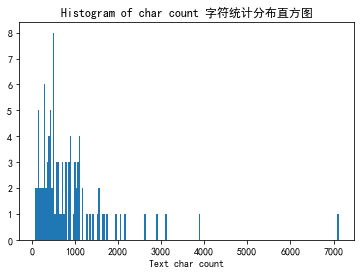

In [14]:
plt.hist(train_df['text_len'], bins=200) #hist直方图
plt.xlabel('Text char count')
plt.title("Histogram of char count 字符统计分布直方图")

全量数据：![image-20200722205328343](pics/image-20200722205328343.png)
#### label分布

Text(0.5, 0, 'category')

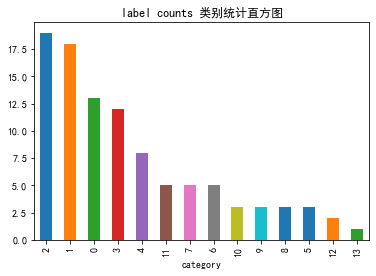

In [15]:
train_df['label'].value_counts().plot(kind='bar')
plt.title('label counts 类别统计直方图')
plt.xlabel('category')

和大多数分类问题一样，同样存在类别不均匀问题，一会在服务器上跑一下全量train数据，如下：
![image-20200722205220885](pics/image-20200722205220885.png)

#### *字符分布统计

平常接触的rawdata通常会分词，所以还是第一次统计字符分布

In [16]:
from collections import Counter
all_lines = ' '.join(list(train_df['text'])) # 以空格链接每一段话
word_count = Counter(all_lines.split(" ")) # 由于每段话都是空格分割的，转成Counter类型
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True) # 按[1]列倒序排序

print("字的种类：{}".format(len(word_count)))

print(word_count[0])

print(word_count[-1])

字的种类：2405
('3750', 3702)
('5034', 1)



将训练集中所有的句子进行拼接进而划分为字符，并统计每个字符的个数。

从统计结果中可以看出，在训练集中总共包括6869个字，其中编号3750的字出现的次数最多，编号3133的字出现的次数最少。

这里还可以根据字在每个句子的出现情况，反推出标点符号。下面代码统计了不同字符在句子中出现的次数，其中字符3750，字符900和字符648在20w新闻的覆盖率接近99%，很有可能是标点符号。

In [17]:
train_df['text_unique'] = train_df['text'].apply(lambda x: ' '.join(list(set(x.split(' ')))))
all_lines = ' '.join(list(train_df['text_unique']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:int(d[1]), reverse = True)


### **数据分析的结论**

通过上述分析我们可以得出以下结论：

1. 赛题中每个新闻包含的字符个数平均为1000个，还有一些新闻字符较长；
2. 赛题中新闻类别分布不均匀，科技类新闻样本量接近4w，星座类新闻样本量不到1k；
3. 赛题总共包括7000-8000个字符；

通过数据分析，我们还可以得出以下结论：

1. **每个新闻平均字符个数较多，可能需要截断；**

2. 由于类别不均衡，会严重影响模型的精度；

### **本章小结**

本章对赛题数据进行读取，并新闻句子长度、类别和字符进行了可视化分析。

### **本章作业**

1.假设字符3750，字符900和字符648是句子的标点符号，请分析赛题每篇新闻平均由多少个句子构成？

In [18]:
# 假设结尾和平时的短信一样有标准标点符号
key = 0
part = []
for line in train_df['text']:
    for piece in line.split(' '):
        if piece in ['3750','900','648']:
            key+=1
    part.append(key)
    key=0

mean=sum(part) / len(part)
mean

77.27

2.统计每类新闻中出现次数对多的字符

In [19]:
sequence=[]
for i in train_df['label'].unique():
    res=' '.join(train_df[train_df['label']==i]['text'])#每个类别所有文本连接后的结果
    sequence.append(res)


In [20]:
m=0
dic={}
word=''
r=[]
for i in sequence:
    for j in i.split(' '):
        dic[j]=dic.setdefault(j,0)+1
        if (dic[j]>m) and (j not in['3750','900','648']):
            word=j
            m=dic[j]
    r.append(word)
    m=0
    dic={}
    word=''
r

['4704',
 '5310',
 '2465',
 '3370',
 '2999',
 '6220',
 '6122',
 '3370',
 '4464',
 '3370',
 '2555',
 '4939',
 '913',
 '2151']